# Standard Packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

# The Model

In [ ]:
class Initializer:
  class normal:
    def __call__(self, shape): return tf.random.normal(shape)

  class spherical:
    def __call__(self, shape):
      X = tf.random.normal(shape)
      return (shape[1]**0.5)*tf.math.l2_normalize(X, axis=1)

In [ ]:
class Model(tf.Module):
  def __init__(self, N, n, d, _lambda=0., n_test=None, r=1., s=0.,
               initializer=Initializer.normal(),
               activation="linear"):
    self.initializer = initializer
    if type(activation) == str:
      self.activation = tf.keras.layers.Activation(activation).activation
    else:
      self.activation = activation

    self._N = N
    self._n = n
    self._d = d
    self._lambda = _lambda

    self._psi_1 = N/float(d)
    self._psi_2 = n/float(d)

    self._a = tf.Variable(r*self.initializer((1,self._N))[0])
    self._theta = tf.Variable(self.initializer((self._N,d)))

    self._a0 = tf.identity(self._a)
    self._beta0 = self.initializer((1,d))[0]

    self._s = s

    self.X_train = self.initializer((n,d))
    noise_train = (s)*self.initializer((n,))
    self.Y_train = tf.tensordot(self.X_train/(d**0.5), self._beta0, 1) + noise_train

    self._n_test = n_test
    if not n_test: self._n_test = n
    self.X_test = self.initializer((n_test,d))
    noise_test = (s)*self.initializer((n_test,))
    self.Y_test = tf.tensordot(self.X_test/(d**0.5), self._beta0, 1) + noise_test

  @tf.function
  def Z(self, X):
    W = tf.tensordot(X, tf.transpose(self._theta), 1) / (self._d**0.5)
    return self.activation(W)

  @tf.function
  def __call__(self, X):
    Z = self.Z(X)
    return tf.tensordot(Z/(self._N**0.5), self._a, 1)

  @tf.function
  def lsq(self):
    Z1 = self.Z(self.X_train)/self._N**0.5
    TMP = tf.tensordot(tf.transpose(Z1), Z1, 1) + self._n/self._N * self._lambda * tf.eye(self._N)
    TMP_inv = tf.linalg.inv(TMP)
    a_lsq = tf.tensordot(tf.tensordot(TMP_inv, tf.transpose(Z1), 1), self.Y_train, 1)
    return a_lsq

  @tf.function
  def lsq2(self):
    Z1 = self.Z(self.X_train)/self._N**0.5
    a_lsq = tf.linalg.lstsq(
      Z1, tf.expand_dims(self.Y_train, 1), l2_regularizer=self._n/self._N * self._lambda
    )
    a_lsq = tf.squeeze(a_lsq)
    return a_lsq


  @tf.function
  def R_train_lsq(self):
    a_lsq = self.lsq()
    Z1 = self.Z(self.X_train)/self._N**0.5
    Yhat = tf.tensordot(Z1, a_lsq, 1)
    error = (1./self._n)*(tf.norm(self.Y_train - Yhat)**2.)
    reg = (1/self._N)*self._lambda*(tf.norm(a_lsq)**2.)
    return error+ reg


  @tf.function
  def R_test_lsq(self):
    a_lsq = self.lsq()
    Z1 = self.Z(self.X_test)/self._N**0.5
    Yhat = tf.tensordot(Z1, a_lsq, 1)
    error = (1./self._n_test)*(tf.norm(self.Y_test - Yhat)**2.)
    return error

  @tf.function
  def R_test_lsq2(self):
    a_lsq = self.lsq2()
    Z1 = self.Z(self.X_test)/self._N**0.5
    Yhat = tf.tensordot(Z1, a_lsq, 1)
    error = (1./self._n_test)*(tf.norm(self.Y_test - Yhat)**2.)
    return error

  @tf.function
  def R_train_lsq(self):
    a_lsq = self.lsq()
    Z1 = self.Z(self.X_train)/self._N**0.5
    Yhat = tf.tensordot(Z1, a_lsq, 1)
    reg = (1/self._N)*self._lambda*(tf.norm(a_lsq)**2.)
    error = (1./self._n)*(tf.norm(self.Y_train - Yhat)**2.)
    return error+reg

  @tf.function
  def R(self, X, Y, n=None, reg_c=1.0):
    if not n: n = self._n
    error = (1./n)*(tf.norm(Y - self(X))**2.)
    reg = (reg_c/self._N)*self._lambda*(tf.norm(self._a)**2.)
    return error + reg

  def R_train(self):
    return self.R(self.X_train, self.Y_train, n=self._n)

  def R_test(self):
    return self.R(self.X_test, self.Y_test, n=self._n_test, reg_c=0.)

  @tf.function
  def learn(self, dt=0.1):
    R = self.R(self.X_train, self.Y_train)
    grad_a = tf.gradients(R, self._a)[0]
    d_a = -0.5*(self._n)*grad_a*dt
    self._a.assign_add(d_a)

    return self.R_train()

  @tf.function
  def learn_steps(self, dt=0.1, steps=10):
    res = 0.
    for _ in tf.range(steps):
      res = self.learn(dt)
    return res

  @tf.function
  def learn_Tspace_steps(self, dt_steps):
    res = 0.
    for i in tf.range(len(dt_steps)):
      res = self.learn(dt_steps[i])
    return res

  def learn_Tspace(self, Tspace, steps):
    history = []
    DT = np.concatenate([[Tspace[0]],np.diff(Tspace)])

    for i in range( (len(Tspace)-1)//steps ):

      history.append({
          "t": Tspace[steps*i],
          "mse_train": self.R_train().numpy(),
          "mse_test": self.R_test().numpy(),
      })

      print(f"{100*steps*i/len(Tspace):.2f} - {history[-1]['mse_test']}")
      
      self.learn_Tspace_steps(DT[i*steps:(i+1)*steps])
    
    return pd.DataFrame(history).set_index("t")



  def learn_epochs(self, dt=0.1, steps=10, epochs=10):
    history = []
    for epoch in range(epochs):
      history.append({
          "t": epoch*steps*dt,
          "mse_train": self.R_train().numpy(),
          "mse_test": self.R_test().numpy(),
      })

      print(f"{100*epoch/epochs:.2f} - {history[-1]['mse_test']}")
      
      if epoch<epochs-1:
        self.learn_steps(dt, steps)
    
    return pd.DataFrame(history).set_index("t")


# Fig. 13 & Fig. 14

In [ ]:
@tf.function
def customActivation(t): 
  return tf.maximum(t,0)-1/(2*np.pi)**0.5


_d = 200 # update this parameter to match the desired image
_psi = 1.8
_phi = 1.4

config=dict(
    activation = customActivation,
    N=int(_psi*_d),
    n=int(_phi*_d), 
    d=_d,
    r=1.,
    n_test=10000, # (technically, ought to be >> d)
    _lambda=0.01, 
    s=0.0
)

In [ ]:
res = []
for _ in range(10):
  model = Model(**config)
  res.append(model.learn_epochs(dt=0.01, steps=100, epochs=80))

In [ ]:
groundtr = pd.read_csv("mse1.csv")

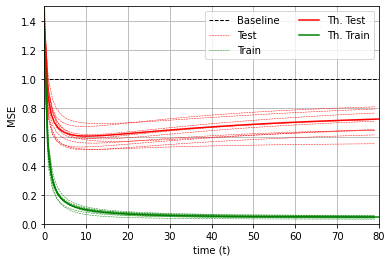

In [ ]:
plt.axhline(1., linestyle="--", color="black", linewidth=1, label="Baseline")

for i,df in enumerate(res):
  plt.plot(df.index, df["mse_test"], "r--", linewidth=0.5, label="Test" if i==0 else None)
  plt.plot(df.index, df["mse_train"], "g--", linewidth=0.5, label="Train" if i==0 else None)

plt.plot(groundtr["Tspace"], groundtr["MSEtest"], "r", label="Th. Test")
plt.plot(groundtr["Tspace"], groundtr["MSEtrain"], "g", label="Th. Train")

# Global

plt.xlabel("time (t)")
plt.ylabel("MSE")

plt.legend(ncol=2)
plt.grid()
plt.xlim(0., 80.)
plt.ylim(0., 1.5)
plt.show()

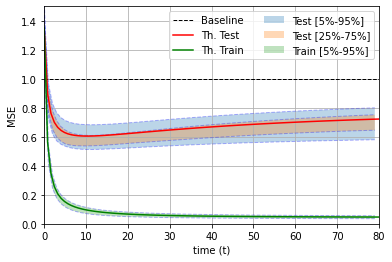

In [ ]:
ts = np.array([df["mse_test"] for df in res])
T_SPACE = res[0].index

tinf = np.quantile(ts, 0.05, axis=0)
tsup = np.quantile(ts, 0.95, axis=0)

plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"Test [5%-95%]")
plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

tinf = np.quantile(ts, 0.25, axis=0)
tsup = np.quantile(ts, 0.75, axis=0)
plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"Test [25%-75%]")
plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)


plt.axhline(1., linestyle="--", color="black", linewidth=1, label="Baseline")

# MSE Train

ts = np.array([df["mse_train"] for df in res])


tinf = np.quantile(ts, 0.05, axis=0)
tsup = np.quantile(ts, 0.95, axis=0)

plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"Train [5%-95%]")
plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

# Real train test

plt.plot(groundtr["Tspace"], groundtr["MSEtest"], "r", label="Th. Test")
plt.plot(groundtr["Tspace"], groundtr["MSEtrain"], "g", label="Th. Train")


# Global

plt.xlabel("time (t)")
plt.ylabel("MSE")

plt.xlim(0., 80.)
plt.ylim(0., 1.5)
plt.legend(ncol=2)
plt.grid()
plt.show()

# Fig. 15

In [ ]:
@tf.function
def customActivation(t): 
  return tf.maximum(t,0)-1/(2*np.pi)**0.5


_d = 100
_psi = 300
_phi = 3

config=dict(
    activation = customActivation,
    N=int(_psi*_d),
    n=int(_phi*_d), 
    d=_d,
    r=2.,
    n_test=10000,
    _lambda=0.1,
    s=0.4
)

In [ ]:
res = []

for i in range(10):
  print(i)

  model = Model(**config)
  df = model.learn_epochs(dt=0.01, steps=1, epochs=1000)
  df2 = model.learn_epochs(dt=0.01, steps=10000, epochs=100)

  df2.index += df.index[-1]
  dfTot = df.drop(df.index[0]).drop(df.index[-1]).append(df2)

  res.append(dfTot)

In [ ]:
df0 = pd.read_csv("doubleTrainingDescent.csv")

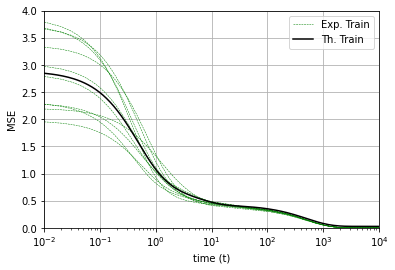

In [ ]:
legend = True
for df in res:
  plt.semilogx(df.index, df["mse_train"],  "g--", linewidth=0.5, label="Exp. Train" if legend else None)
  legend = False

plt.semilogx(df0.Tspace, df0["MSEtrain"], "black", label="Th. Train")

plt.ylim(0,4.)
plt.xlim(1e-2, 1e4)
plt.grid()
plt.legend()
plt.xlabel("time (t)")
plt.ylabel("MSE")
plt.show()

# Fig. 16

In [ ]:
mu = 0.5
nu = 0.3

@tf.function
def customActivation(t): 
  return mu*t + (0.5**0.5)*nu*(t**2 - 1)

_d = 100
_psi = 6.0

_phi = 3.0

config=dict(
    activation = customActivation, #"linear"
    N=int(_psi*_d),
    n=int(_phi*_d), 
    d=_d,
    r=2.,
    n_test=10000,
    _lambda=0.0001, #1
    s=0.4
)

In [ ]:
res = []

for i in range(10):
  print(f"#### Test {i} ###")
  model = Model(**config)
  df = model.learn_epochs(dt=0.01, steps=1, epochs=1000)
  df2 = model.learn_epochs(dt=0.01, steps=1000, epochs=1000)
  df3 = model.learn_epochs(dt=0.1, steps=100000, epochs=100)

  df2.index += df.index[-1]
  df3.index += df2.index[-1]
  dfTot = (df
          .drop(df.index[0])
          .drop(df.index[-1])
          .append(df2.drop(df2.index[-1]))
          .append(df3.drop(df3.index[-1]))
  )

  res.append(dfTot)

In [ ]:
dfTh = pd.read_csv("doubleTestDescent.csv")

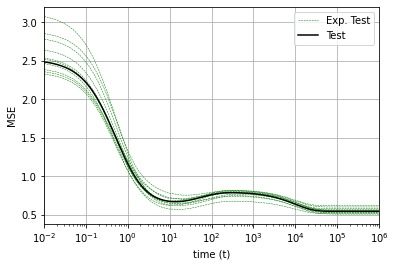

In [ ]:
legend = True
for df in res:
  plt.semilogx(df.index, df["mse_test"],  "g--", linewidth=0.5, label="Exp. Test" if legend else None)
  legend = False

plt.semilogx(dfTh.Tspace, dfTh["MSEtest"], "black", label="Test")
plt.xlim(1e-2, 1e6)

plt.legend()
plt.xlabel("time (t)")
plt.ylabel("MSE")
plt.grid()
plt.show()

# Fig. 2

In [ ]:
mu = 10.0
nu = 1.0

@tf.function
def customActivation(t): 
  return mu*t + (0.5**0.5)*nu*(t**2 - 1)

_d = 5000
_psi = 2.0

runtime_parameters=dict(
    dt=0.01,
    steps=10,
    epochs=1000
)

cSpace = np.linspace(0.1, 2., 40)

MSEtest2 = []
MSEtest2_std = []
MSEtrain = []
MSEtrain_std = []

n_runs = 10

for c in cSpace:
  config=dict(
      activation = customActivation, #"linear"
      N=int(_psi*_d),
      n=int(_psi*c*_d), 
      d=_d,
      n_test=10000,
      _lambda=0.01, #1
      s=0.5
  )

  ltest = np.zeros(n_runs)
  ltrain = np.zeros(n_runs)

  print(model._N, model._n)

  for i in range(n_runs):
    model = Model(**config)
    ltest[i] = model.R_test_lsq2().numpy()
    ltrain[i] = model.R_train_lsq().numpy()

  MSEtest2.append(ltest.mean())
  MSEtrain.append(ltrain.mean())
  MSEtest2_std.append(ltest.std())
  MSEtrain_std.append(ltrain.std())


In [ ]:
df = pd.read_csv("triple_descent_profile.csv")

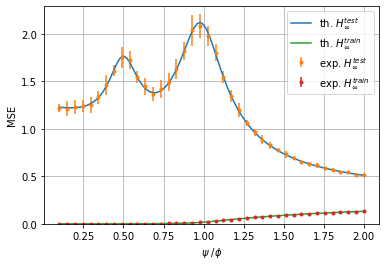

In [ ]:
plt.plot(df["c"], df["MSEtest"], label=r"th. $H^{test}_\infty$")
plt.errorbar(cSpace, MSEtest2, 2*np.array(MSEtest2_std), linestyle='None', marker='.', label="exp. $H^{test}_\infty$")
plt.plot(df["c"], df["MSEtrain"], label=r"th. $H^{train}_\infty$")
plt.errorbar(cSpace, MSEtrain, 2*np.array(MSEtrain_std), linestyle='None', marker='.', label="exp. $H^{train}_\infty$")
plt.xlabel("$\psi ~/ \phi$")
plt.ylabel("MSE")
plt.grid()
plt.ylim(0.,1.1*np.max(MSEtest2))
plt.legend()
plt.show()

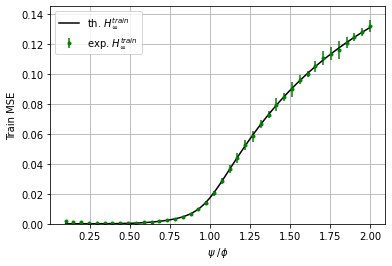

In [ ]:
plt.plot(df["c"], df["MSEtrain"], label=r"th. $H^{train}_\infty$", color="black")
plt.errorbar(cSpace, MSEtrain, 2*np.array(MSEtrain_std), linestyle='None', marker='.', color="green",  label="exp. $H^{train}_\infty$")
plt.xlabel("$\phi ~/ \psi$")
plt.ylabel("Train MSE")
plt.grid()
plt.ylim(0.,1.1*np.max(MSEtrain))
plt.legend()
plt.show()

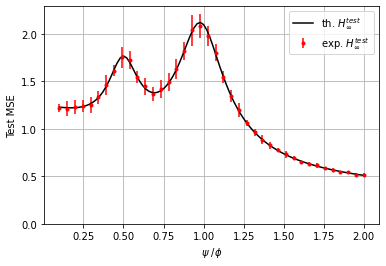

In [ ]:
plt.plot(df["c"], df["MSEtest"], label=r"th. $H^{test}_\infty$", color="black")
plt.errorbar(cSpace, MSEtest2, 2*np.array(MSEtest2_std), linestyle='None', marker='.', label="exp. $H^{test}_\infty$", color="red")
plt.xlabel("$\phi ~/ \psi$")
plt.ylabel("Test MSE")
plt.grid()
plt.ylim(0.,1.1*np.max(MSEtest2))
plt.legend()
plt.show()